In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def prepare_for_fitness_calculation(df : pd.DataFrame, N_c : int, min_current=None, input1_col='I1', input2_col='I2',
    gate_col='G', control_col='C', current_col='Current', off_state=0.0, on_state=0.01) -> pd.DataFrame:
    """
    Prepares a pandas Dataframe of electric currents for calculation of gate fitnesses\\
    Number of Controls NC must be provided as argument\\
    Allows to exclude any currents having an absolute value less than min_current if min_current != None\\
    Allows to check df if for each voltage combination exactly all possible input states are present\\ 
    Other Attributes define column names for various features
    """

    # Sort Dataframe by C1,C2,..G,I1,I2 and exclude Currents if min_current != None
    sort_cols = [control_col + '{}'.format(i) for i in range(1, N_c + 1)]
    sort_cols.extend([gate_col, input1_col, input2_col])
    
    data    = df.copy()
    
    if min_current != None:
        # data.loc[data[current_col].abs() <= min_current, current_col] = min_current
        data = data[data[current_col].abs() > min_current]
    
    data    = data.sort_values(by=sort_cols)
    data    = data.reset_index(drop=True)

    # Move through each row and proof that for each electrode voltage combination all possible input states are present
    i       = 0
    rows    = np.floor(len(data))

    while (i < rows):

        try:

            cond1 = ((data[input1_col][i]   == off_state) and (data[input2_col][i]   == off_state))
            cond2 = ((data[input1_col][i+1] == off_state) and (data[input2_col][i+1] == on_state))
            cond3 = ((data[input1_col][i+2] == on_state)  and (data[input2_col][i+2] == off_state))
            cond4 = ((data[input1_col][i+3] == on_state)  and (data[input2_col][i+3] == on_state))
            
            cond5 = (data[gate_col][i] == data[gate_col][i+1]) 
            cond6 = (data[gate_col][i] == data[gate_col][i+2]) 
            cond7 = (data[gate_col][i] == data[gate_col][i+3])

            cond8 = (data[control_col + '1'][i] == data[control_col + '1'][i+1]) 
            cond9 = (data[control_col + '1'][i] == data[control_col + '1'][i+2]) 
            cond10= (data[control_col + '1'][i] == data[control_col + '1'][i+3])
        
        except:

            try:
                data = data.drop(i)
            except:
                pass

            try:
                data = data.drop(i+1)
            except:
                pass

            try:
                data = data.drop(i+2)
            except:
                pass

            data = data.reset_index(drop=True)
            break

        if not(cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7 and cond7 and cond8 and cond9 and cond10):

            data    = data.drop(i)
            data    = data.reset_index(drop=True)
            rows    = rows - 1
            continue

        i = i + 4
    
    return data

def get_on_off_rss(df00 : pd.DataFrame, df01 : pd.DataFrame, df10 : pd.DataFrame, df11 : pd.DataFrame, gate : str, all=False) -> pd.DataFrame:
    """
    Get off and on state for fitness calculation for gate provided as string\\
    Get residual sums of squares as sqrt(RSS/4)
    """

    df = pd.DataFrame()

    if gate == 'AND':

        df['off']   = (df00['Current'] + df01['Current'] + df10['Current'])/3
        df['on']    = df11['Current']
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['on'])**2)/4)

    elif gate == 'OR':

        df['off']   = df00['Current']
        df['on']    = (df01['Current'] + df10['Current'] + df11['Current'])/3
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['on'])**2)/4)

    elif gate == 'XOR':

        df['off']   = (df00['Current'] + df11['Current'])/2
        df['on']    = (df01['Current'] + df10['Current'])/2
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['off'])**2)/4)

    elif gate == 'NAND':

        df['on']    = (df00['Current'] + df01['Current'] + df10['Current'])/3
        df['off']   = df11['Current']
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['off'])**2)/4)

    elif gate == 'NOR':

        df['on']    = df00['Current']
        df['off']   = (df01['Current'] + df10['Current'] + df11['Current'])/3
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['off'])**2)/4)

    elif gate == 'XNOR':

        df['on']    = (df00['Current'] + df11['Current'])/2
        df['off']   = (df01['Current'] + df10['Current'])/2
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['on'])**2)/4)
    
    elif gate == 'P':

        df['on']    = (df10['Current'] + df11['Current'])/2
        df['off']   = (df00['Current'] + df01['Current'])/2
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['on'])**2)/4)
    
    elif gate == 'notP':

        df['on']    = (df00['Current'] + df01['Current'])/2
        df['off']   = (df10['Current'] + df11['Current'])/2
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['off'])**2)/4)

    elif gate == 'Q':

        df['on']    = (df01['Current'] + df11['Current'])/2
        df['off']   = (df00['Current'] + df10['Current'])/2
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['on'])**2)/4)
    
    elif gate == 'notQ':

        df['on']    = (df00['Current'] + df10['Current'])/2
        df['off']   = (df01['Current'] + df11['Current'])/2
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['off'])**2)/4)

    elif gate == 'PnotQ':

        df['on']    = df10['Current']
        df['off']   = (df00['Current'] + df01['Current'] + df11['Current'])/3
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['off'])**2)/4)
    
    elif gate == 'notPQ':

        df['on']    = df01['Current']
        df['off']   = (df00['Current'] + df10['Current'] + df11['Current'])/3
        df['res']   = np.sqrt(((df00['Current'] - df['off'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['off'])**2)/4)
    
    elif gate == 'notPandQ':

        df['on']    = (df00['Current'] + df01['Current'] + df11['Current'])/3
        df['off']   = df10['Current']
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['on'])**2 + (df10['Current'] - df['off'])**2 + (df11['Current'] - df['on'])**2)/4)
    
    elif gate == 'PandnotQ':

        df['on']    = (df00['Current'] + df10['Current'] + df11['Current'])/3
        df['off']   = df01['Current']
        df['res']   = np.sqrt(((df00['Current'] - df['on'])**2 + (df01['Current'] - df['off'])**2 + (df10['Current'] - df['on'])**2 + (df11['Current'] - df['on'])**2)/4)

    return df

def fitness(df : pd.DataFrame, N_controls : int, delta=0.01, min_current=None, off_state=0.0, on_state=0.01,
    gates=['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR'], input1_column = 'I1', input2_column = 'I2', gate_column = 'G',
    controls_column = 'C', current_column = 'Current', error_column='Error') -> pd.DataFrame:
    """
    Calculate Fitness based on m/(sqrt(RSS/4) + delta*|c|)\\
    Input pandas Dataframe of electric currents and provide number of controls Nc\\
    Before starting the fitness calculation: Allows to exclude any currents having an absolute value less than min_current and check if all possible input states are present
    """

    if min_current != None:
        df = prepare_for_fitness_calculation(df=df, N_c=N_controls, min_current=min_current, input1_col=input1_column, input2_col=input2_column,
                                             gate_col=gate_column, control_col=controls_column, current_col=current_column, off_state=off_state, on_state=on_state)

    columns         = [gate_column] + [controls_column + '{}'.format(i) for i in range(1, N_controls+1)]
    
    df00            = df.copy()
    df00            = df00[(df00[input1_column] == off_state) & (df00[input2_column] == off_state)]
    df00            = df00.sort_values(by=columns)
    df00            = df00.reset_index(drop=True)

    df01            = df.copy()
    df01            = df01[(df01[input1_column] == off_state) & (df01[input2_column] == on_state)]
    df01            = df01.sort_values(by=columns)
    df01            = df01.reset_index(drop=True)
 
    df10            = df.copy()
    df10            = df10[(df10[input1_column] == on_state) & (df10[input2_column] == off_state)]
    df10            = df10.sort_values(by=columns)
    df10            = df10.reset_index(drop=True)

    df11            = df.copy()
    df11            = df11[(df11[input1_column] == on_state) & (df11[input2_column] == on_state)]
    df11            = df11.sort_values(by=columns)
    df11            = df11.reset_index(drop=True)
    
    # Setup fitness dataframe with columns based on current dataframe columns except inputs and current + error
    fitness         = pd.DataFrame(columns=list(df00.columns) + [g + ' Fitness' for g in gates])
    if error_column != None:
        fitness         = fitness.drop(columns=[current_column,error_column])
    else:
        fitness         = fitness.drop(columns=[current_column])

    # Input Parameter and init gate fitness as nan
    for col in list(df00.columns):

        if ((col != "Current") and (col != "Error")):
            
            fitness[col] = (df00[col] + df01[col] + df10[col] + df11[col])/4

    # Calculate Fitness for each Gate
    for g in gates:

        df_pre = get_on_off_rss(df00, df01, df10, df11, g)
        
        df_pre['m']                 = df_pre['on'] - df_pre['off']
        df_pre['denom']             = df_pre['res'] + delta*(df_pre['off'].abs())
        fitness[g + ' Fitness']     = df_pre['m']/df_pre['denom']
    
    fitness = fitness.reset_index(drop=True)

    return fitness

def abundance(df : pd.DataFrame, gates=['AND Fitness', 'OR Fitness', 'XOR Fitness', 'NAND Fitness', 'NOR Fitness', 'XNOR Fitness'], bins=0, range=(-1,2)) -> pd.DataFrame:
    """
    Empirical Abundace based on pandas dataframe of fitness values for gates provided as list of strings
    """

    df_abundance = pd.DataFrame()
    
    if type(bins) == int: 
        if bins == 0:
            for gate in gates:

                df_curr = df.copy()

                x = np.sort(np.array(df_curr[gate]))
                
                p_x = 1. * np.arange(len(x)) / float(len(x) - 1)
                
                abundance = 100 - 100*p_x
                
                df_abundance[gate]     = x
                df_abundance[gate+' Abundance']   = abundance
        
        else:
            for gate in gates:
            
                df_curr = df.copy()
                count, bins_count = np.histogram(np.array(df_curr[gate]), bins=bins)#, range=range)
                pdf = count / np.sum(count)
                cdf = np.cumsum(pdf)

                abundance = 100 - 100*cdf
                df_abundance[gate]     = bins_count[:-1]
                df_abundance[gate+' Abundance']   = abundance
    else:

        for gate in gates:
            
            df_curr = df.copy()
            count, bins_count = np.histogram(np.array(df_curr[gate]), bins=bins)#, range=range)
            pdf = count / np.sum(count)
            cdf = np.cumsum(pdf)

            abundance = 100 - 100*cdf
            df_abundance[gate]     = bins_count[:-1]
            df_abundance[gate+' Abundance']   = abundance

    return df_abundance

In [4]:
df_u    = pd.read_csv("uniform.csv")
df_m    = pd.read_csv("memristor.csv")
length  = len(df_u)

In [35]:
min_error   = 0.00
max_error   = 0.2

In [36]:
df_u = df_u[((df_u['Error']/df_u['Current']).abs() >= min_error) & ((df_u['Error']/df_u['Current']).abs() < max_error)]
df_m = df_m[((df_m['Error']/df_m['Current']).abs() >= min_error) & ((df_m['Error']/df_m['Current']).abs() < max_error)]

In [37]:
print(len(df_u)/length)
print(len(df_m)/length)

0.95285
0.94855


In [38]:
column_names    = ['C1','I1','I2','C2','C3','C4','C5','O','G','Eq_Jumps','Jumps','Current','Error']
df_u.columns    = column_names
df_m.columns    = column_names

In [39]:
df_u        = prepare_for_fitness_calculation(df=df_u, N_c=5, min_current=0)
df_m        = prepare_for_fitness_calculation(df=df_m, N_c=5, min_current=0)

bins        = 1000
fitness_u   = fitness(df=df_u, N_controls=5, delta=0.0)
abundance_u = abundance(df=fitness_u, bins=bins)
fitness_m   = fitness(df=df_m, N_controls=5, delta=0.0)
abundance_m = abundance(df=fitness_m, bins=bins)

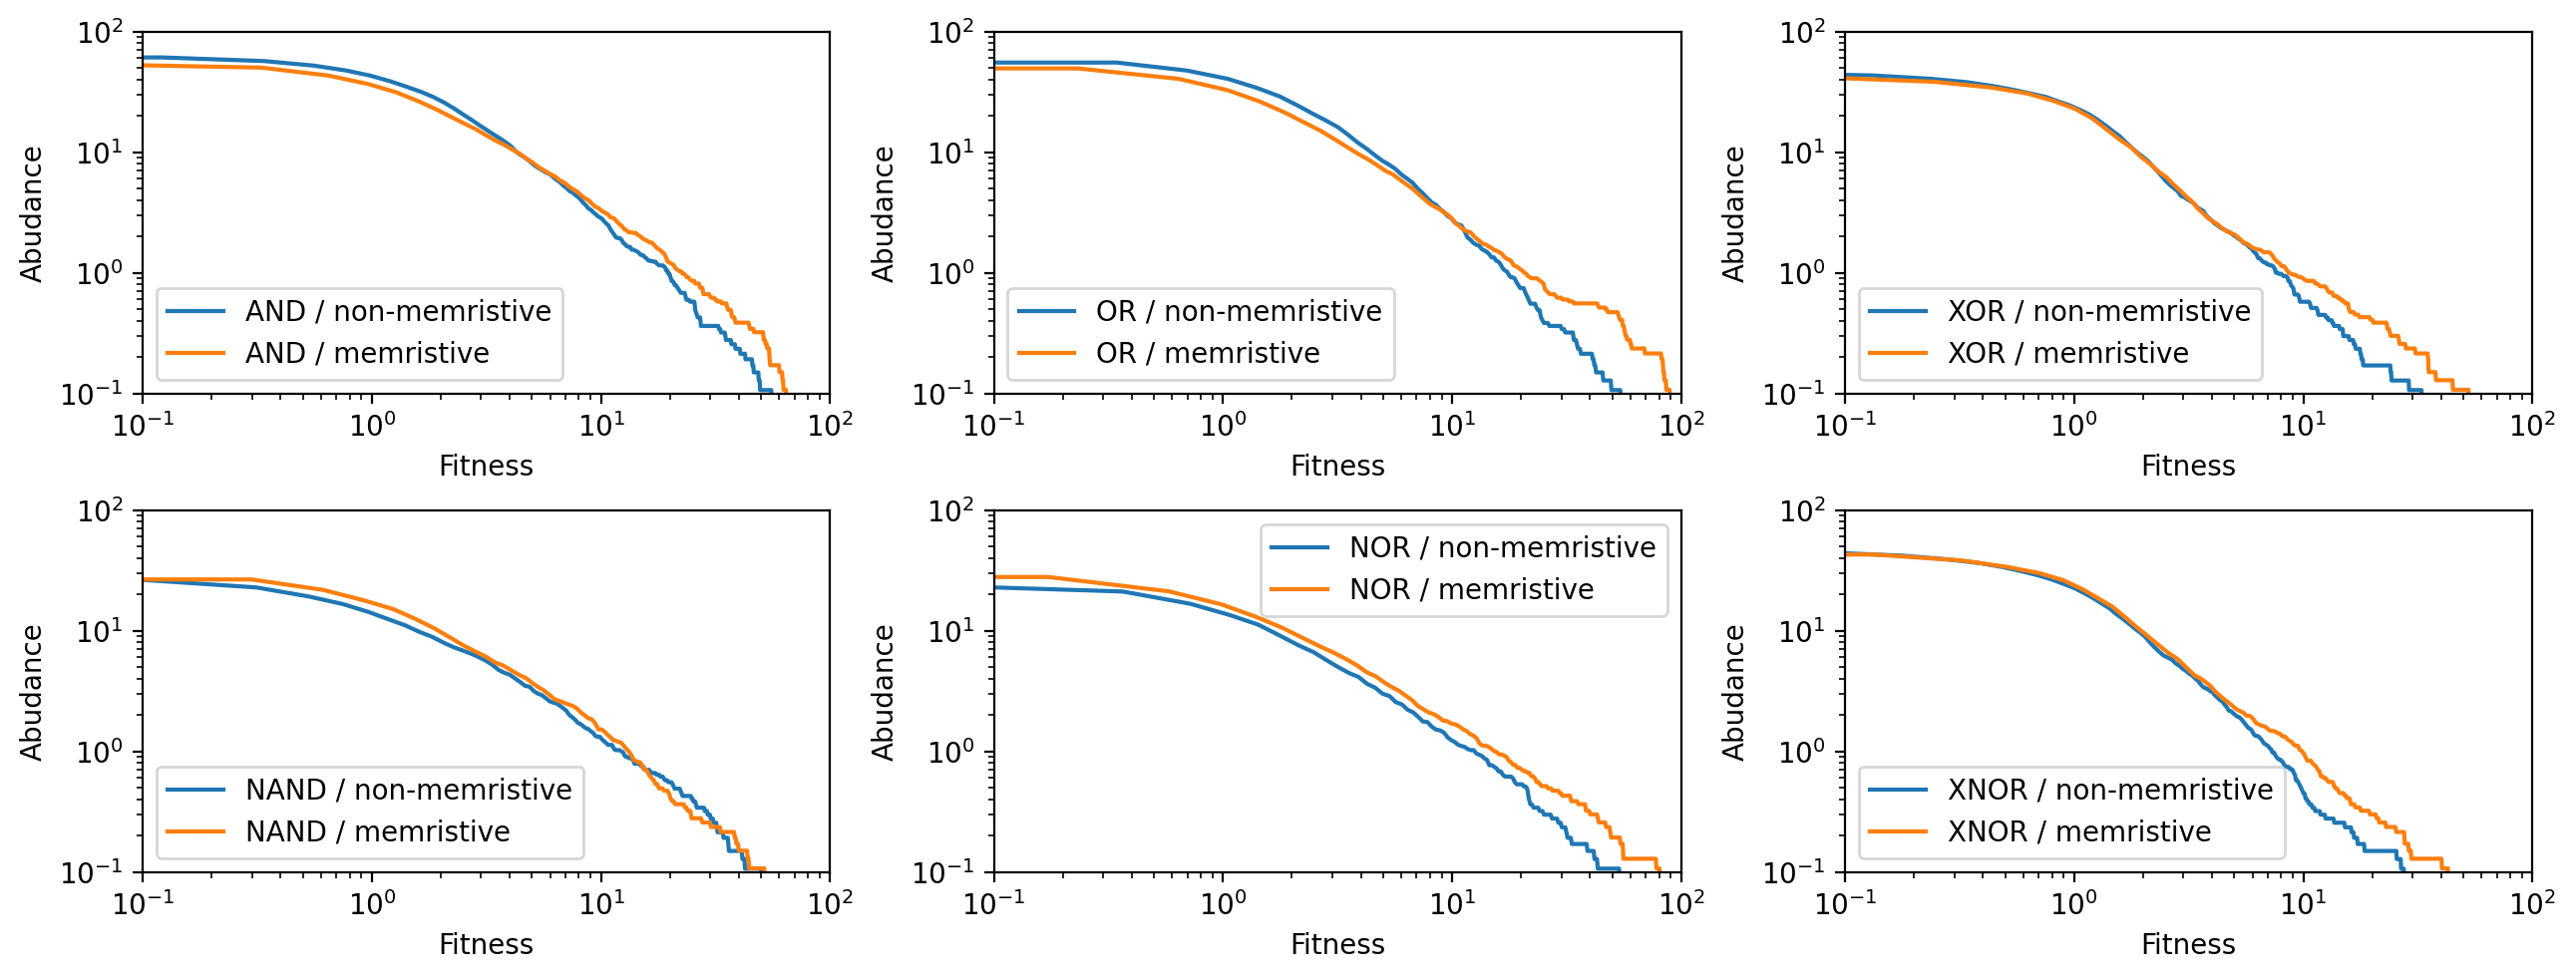

In [40]:
fig = plt.figure(layout='constrained', dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)

for i, gate in enumerate(['AND','OR','XOR','NAND','NOR','XNOR']):

    ax  = fig.add_subplot(2,3,i+1)

    ax.plot(abundance_u[f'{gate} Fitness'], abundance_u[f'{gate} Fitness Abundance'], label=f'{gate} / non-memristive')
    ax.plot(abundance_m[f'{gate} Fitness'], abundance_m[f'{gate} Fitness Abundance'], label=f'{gate} / memristive')

    ax.set_ylim(0.1,100)
    ax.set_xlim(0.1,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Abudance')
    ax.set_xlabel('Fitness')
    ax.legend()

    fig.savefig(f'comparsion_max_error_{max_error}.png')

In [41]:
def nonlinear_parameter(df : pd.DataFrame, input1_column = 'I1', input2_column = 'I2', current_column='Current', on_state=0.01, off_state=0)->pd.DataFrame:

    currents    = pd.DataFrame()

    df_1 = df[df[input1_column] == off_state]
    df_1 = df_1[df_1[input2_column] == off_state]
    df_1 = df_1.reset_index(drop=True)
    currents['I00'] = df_1[current_column]

    df_1 = df[df[input1_column] == off_state]
    df_1 = df_1[df_1[input2_column] == on_state]
    df_1 = df_1.reset_index(drop=True)
    currents['I01'] = df_1[current_column]

    df_1 = df[df[input1_column] == on_state]
    df_1 = df_1[df_1[input2_column] == off_state]
    df_1 = df_1.reset_index(drop=True)
    currents['I10'] = df_1[current_column]

    df_1 = df[df[input1_column] == on_state]
    df_1 = df_1[df_1[input2_column] == on_state]
    df_1 = df_1.reset_index(drop=True)
    currents['I11'] = df_1[current_column]

    currents    = currents.replace(0, np.nan)
    currents    = currents.dropna()
    currents    = currents.reset_index(drop=True)

    df_new = pd.DataFrame()

    df_new['Iv']    = (currents["I11"] + currents["I10"] + currents["I01"] + currents["I00"])/4
    df_new['Ml']    = (currents["I11"] + currents["I10"] - currents["I01"] - currents["I00"])/4
    df_new['Mr']    = (currents["I11"] - currents["I10"] + currents["I01"] - currents["I00"])/4
    df_new['X']     = (currents["I11"] - currents["I10"] - currents["I01"] + currents["I00"])/4

    return df_new

def expected_value(arr : np.array, order=1, bins=1000)->float:

    count, bins = np.histogram(a=arr, bins=bins)
    probs       = count / np.sum(count)
    mids        = 0.5*(bins[1:]+ bins[:-1])
    exp_val     = np.sum(probs * mids**order)

    return exp_val

def return_ndr(arr : np.array)->np.array:
    return (1 - np.tanh(np.mean(arr)/np.std(arr)))/2

def return_nls(df : pd.DataFrame, ml_col='Ml', mr_col='Mr', x_col='X', bins=1000)->np.array:
    return expected_value(df[x_col].values, order=2, bins=bins)/(expected_value(df[ml_col].values, order=2, bins=bins) + expected_value(df[mr_col].values, order=2, bins=bins))


In [42]:
params_u = nonlinear_parameter(df_u)
params_m = nonlinear_parameter(df_m)

In [43]:
print(f"Q_NDR(Memristor): {np.round(return_ndr(params_m['Ml'].values),2)}")
print(f"Q_NDR(Uniform): {np.round(return_ndr(params_u['Ml'].values),2)}")

Q_NDR(Memristor): 0.45
Q_NDR(Uniform): 0.37


In [44]:
print(f"Q_NLS(Memristor): {np.round(return_nls(params_m),2)}")
print(f"Q_NLS(Uniform): {np.round(return_nls(params_u),2)}")

Q_NLS(Memristor): 0.47
Q_NLS(Uniform): 0.41
